In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix

# prepare data

In [2]:
dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak']
splits = ['train', 'test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = {}
for dset in tqdm(dsets):
    for split in splits:
        df = data.get_data(dset=dset)
        df = df[~(df.short | df.long | df.hotspots)]
#         df = df[df.valid]
        df = df[df.lifetime > 15] # only keep hard tracks
        df = df[df.cell_num.isin(config.DSETS[dset][split])] # exclude held-out test data
        feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        length = 40
        df['X_same_length'] = [features.downsample(df.iloc[i]['X'], length)
                               for i in range(len(df))] # downsampling
        # normalize tracks
        df = features.normalize_track(df, track='X_same_length', by_time_point=False)

        # regression response
        df = train_reg.add_sig_mean(df)     

        # remove extraneous feats
        # df = df[feat_names + meta]
#         df = df.dropna() 

        # normalize features
        for feat in feat_names:
            if 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)

        dfs[(dset, split)] = deepcopy(df)

100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


## train neural net with cv

In [102]:
df_train = dfs[('clath_aux+gak_a7d2_new', 'train')]
print(os.listdir(DIR_RESULTS))
out_dir = f'{DIR_RESULTS}/dec13_deep_best'
# out_dir = f'results/regression/deep_learning/Dec11'

['mar19_2', 'maxconv', 'aug19_binary1', 'mar19_1', 'clips', 'dec12_deep_H=80', 'dec8_1', 'dec10_deep', 'apr28_1', 'dec13_deep_best', 'may7_1', 'dec10_cnn', 'may6_1', 'mar19_3', 'dec12_deep', 'dec12_deep_H=20', 'nov16', 'dec10_lstm']


In [ ]:
os.makedirs(out_dir, exist_ok=True)
outcome_def = 'Y_sig_mean_normalized'
num_epochs = 100
num_hidden = 40
for model_type in ['nn_lstm']: #['nn_cnn', 'fcnn', 'nn_lstm']: # = 'nn_cnn' # 'nn_lstm', 'fcnn', 'nn_cnn', 'nn_attention'
    train_reg.train_reg(df_train,
                        feat_names=feat_names,
                        track_name='X_same_length_normalized',
                        model_type=model_type, 
                        outcome_def=outcome_def,
                        out_name=oj(out_dir, f'{dset}_{outcome_def}_{model_type}_{num_epochs}_{num_hidden}.pkl'),
                        fcnn_hidden_neurons=num_hidden,
                        fcnn_epochs=num_epochs)

**analyze cv results**

In [23]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['r2'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r[['pearsonr', 'r2']]

{'r2': [0.3410249004640089, 0.3208547273943092, 0.4126897499403642, 0.3594438570984312, 0.36538168636939417, 0.408612136123226, 0.3859741881617027, 0.4261156649998624], 'pearsonr': [0.5854548719270554, 0.56699047930762, 0.6433357214073335, 0.601086041946158, 0.6045239439241363, 0.6392560386371637, 0.6236078945096376, 0.6549200084527723]}
dict_keys(['r2', 'pearsonr'])


,pearsonr,r2
model_type,,
clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40,0.615,0.377


## train neural net on all training data

In [3]:
df_full = pd.concat([dfs[(k, s)]
                     for (k, s) in dfs
                     if s == 'train'])[feat_names + ['Y_sig_mean_normalized', 'y_consec_sig']]
df_full = df_full.dropna()

In [ ]:
np.random.seed(42)
checkpoint_fname = '../models/dnn_full_long_normalized_across_track_4_feats.pkl'
dnn = neural_networks.neural_net_sklearn(D_in=40, H=40, p=3, arch='lstm', epochs=100)
dnn.fit(df_full[feat_names[:4]], df_full['Y_sig_mean_normalized'].values, verbose=True, checkpoint_fname=checkpoint_fname)
pkl.dump({'model_state_dict': dnn.model.state_dict()}, open(checkpoint_fname, 'wb'))

# transfer to classification

In [10]:
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_4_feats.pkl', 'rb'))
# results = pkl.load(open('../models/clath_aux+gak_a7d2_new_Y_sig_mean_normalized_nn_lstm_100_40.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=40, p=3, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

<All keys matched successfully>

In [11]:
R = 2
C = len(dfs) // 2

# exclude the training data
ds = {(k, v): dfs[(k, v)]
      for (k, v) in sorted(dfs.keys(), key=lambda x: x[1] + x[0])
      #if not k == 'clath_aux+gak_a7d2_new'
     }


plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    X = df[feat_names[:4]]
    y = df['y_consec_thresh']
    preds = dnn.predict(X)
    
    plt.subplot(R, C, i + 1)
    y_pred = (preds > 0).astype(int)
    acc = np.mean(y_pred == y)
    print(k, v, np.mean(y), acc)
    plt.title(f'{k} {v} {100*acc:0.1f}%', fontsize=10)
    plt.hist(preds[y==0], alpha=1, label='aux-')
    plt.hist(preds[y==1], alpha=0.5, label='aux+')
    plt.yscale('log')
    plt.xlabel('pred')
    
    if i == 0:
        plt.legend()

clath_aux+gak test 0.5220125786163522 0.779874213836478
clath_aux+gak_a7d2 test 0.42686567164179107 0.709452736318408
clath_aux+gak_a7d2_new test 0.6462912087912088 0.5782967032967034
clath_aux+gak_new test 0.3333333333333333 0.8230647709320695
clath_gak test 0.4761182714177407 0.7581501137225171
clath_aux+gak train 0.591764705882353 0.7835294117647059
clath_aux+gak_a7d2 train 0.5047683923705722 0.7626021798365122
clath_aux+gak_a7d2_new train 0.6879882092851879 0.3714075165806927
clath_aux+gak_new train 0.5183156453269429 0.7942485450188291
clath_gak train 0.4062005694400506 0.7459664663081303


clath_aux+gak test
clath_aux+gak_a7d2 test
clath_aux+gak_a7d2_new test
clath_aux+gak_new test
clath_gak test
clath_aux+gak train
clath_aux+gak_a7d2 train
clath_aux+gak_a7d2_new train
clath_aux+gak_new train
clath_gak train


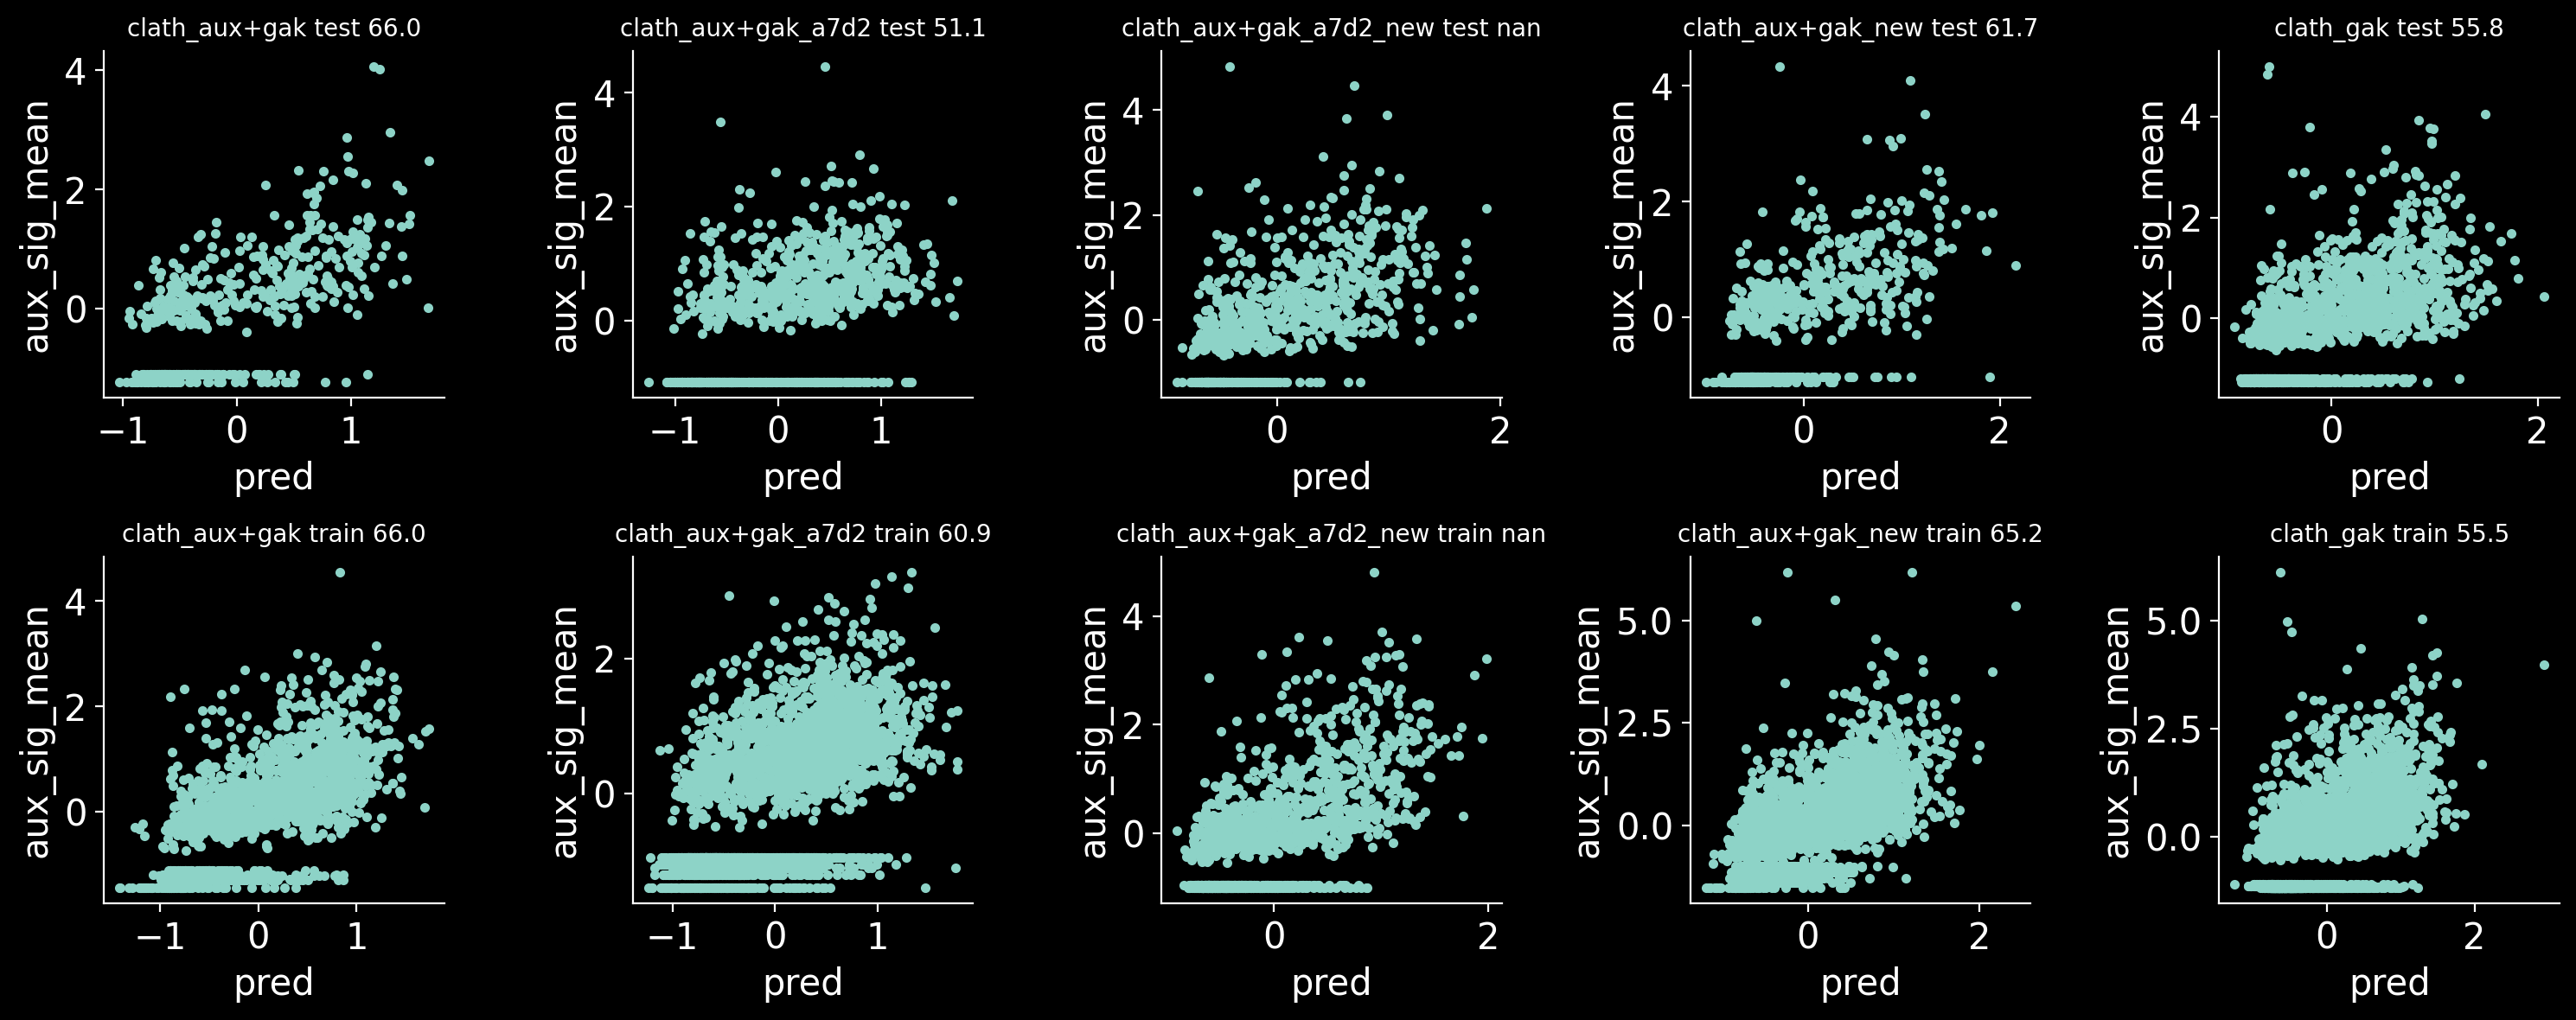

In [57]:
R = 2
C = len(dfs) // 2 

plt.figure(dpi=200, figsize=(C * 3, R * 3))
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    X = df[feat_names]
    y = df['Y_sig_mean_normalized']
    preds = dnn.predict(X)
    
    plt.subplot(R, C, i + 1)
    acc = np.corrcoef(preds, y)[0, 1]
    print(k, v) #, np.corrcoef(preds, y))
    plt.title(f'{k} {v} {100*acc:0.1f}', fontsize=10)    
    plt.plot(preds, df['Y_sig_mean_normalized'], '.')
    plt.xlabel('pred')
    plt.ylabel('aux_sig_mean')
plt.show()

In [9]:
gb = GradientBoostingRegressor()
gb.fit(df_full[feat_names[1:]], df_full['Y_sig_mean_normalized'].values)

GradientBoostingRegressor()

In [ ]:
    df = ds[('clath_aux+gak', 'test')]
    X = df[feat_names]
    y = df['Y_sig_mean_normalized']
    preds_dnn = dnn.predict(X)
    preds_gb = gb.predict(df[feat_names[1:]])

In [37]:
dnn_best = np.argsort(np.abs(preds_dnn - y.values) - np.abs(preds_gb - y.values))[:20]
(np.abs(preds_dnn - y.values))[dnn_best]

array([0.17873058, 0.01286897, 0.97369442, 1.33495522, 2.86769983,
       0.01452866, 0.28488568, 0.5389847 , 0.73012719, 2.1822356 ,
       0.04364294, 0.00459727, 1.91185952, 0.79756683, 0.34557187,
       0.60934306, 0.34762309, 1.33425269, 0.13442096, 0.025408  ])

In [38]:
(np.abs(preds_gb - y.values))[dnn_best]

array([1.13511413, 0.75571952, 1.71499488, 2.05382731, 3.54887148,
       0.69081136, 0.93515968, 1.17842063, 1.29274414, 2.71376034,
       0.55140689, 0.49353518, 2.39592436, 1.28158566, 0.82016086,
       1.08252028, 0.80856234, 1.78840405, 0.5879343 , 0.47635081])

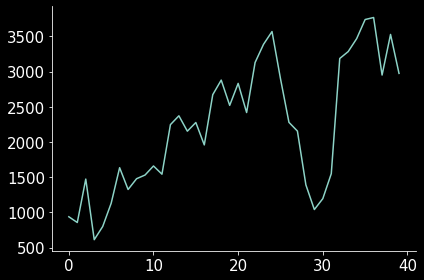

In [39]:
plt.plot(df['X_same_length'].iloc[dnn_best[0]])
preds_dnn[dnn_best[0]]

In [ ]:
R = 3
C = 6

plt.figure(dpi=200, figsize=(C * 4, R * 4))
for i in range(18):
    plt.subplot(R, C, i + 1)
    plt.plot(df['X_same_length'].iloc[dnn_best[i]])
    plt.title(f"y:{y.values[dnn_best[i]]:0.1f}, gb:{preds_gb[dnn_best[i]]:0.1f}, dnn:{preds_dnn[dnn_best[i]]:0.1f}")
    
plt.tight_layout()
plt.show()

In [59]:
df = ds[('clath_aux+gak_a7d2_new', 'test')]
df = df.dropna()
X = df[feat_names]
preds_dnn = dnn.predict(X)
preds_gb = gb.predict(df[feat_names[1:]])
dnn_correct = (preds_dnn > 0).astype(int) == df['y_consec_thresh'].values
gb_correct = (preds_gb > 0).astype(int) == df['y_consec_thresh'].values

In [60]:
confusion_matrix(dnn_correct, gb_correct)

array([[145,  27],
       [ 40, 290]])

In [61]:
np.corrcoef(preds_dnn, preds_gb)[0, 1]

0.8719520625823945

Text(0, 0.5, 'prediction of gradient boosting')

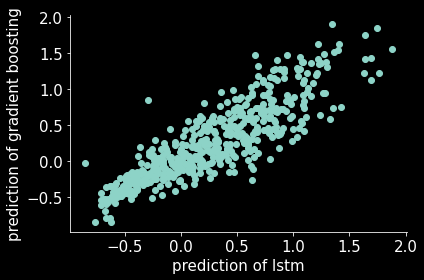

In [63]:
plt.scatter(preds_dnn, preds_gb)
plt.xlabel("prediction of lstm")
plt.ylabel("prediction of gradient boosting")

In [64]:
def normalize_track(df, track='X_same_length'):
    
    """
    normalize tracks
    """
    
    df[f'{track}_normalized'] = df[track].values
    for cell in set(df['cell_num']):
        cell_idx = np.where(df['cell_num'].values == cell)[0]
        y = df[track].values[cell_idx]
        y = np.array(list(y))
        df[f'{track}_normalized'].values[cell_idx] = list((y - np.mean(y, axis=0))/np.std(y, axis=0))
    return df

In [66]:
np.std(np.zeros((8, 6)))

0.0